<h1 align="center">Klasteriranje</h1><br>

Usporedno s razvojem digitalizacije podaci se počinju prikupljati velikom brzinom, pa je obrada skupljenih podataka postala znatno teža. Kako bi se uočila slična svojstva među podacima i otkrile neke nove karakteristike, prirodno se pojavila potreba za grupiranjem podataka. Danas je to jedna od najčešćih tehnika analize podataka. Svoje primjene nalazi u raznim područjima znanosti kao što su strojno učenje, statistika, fizika, biologija, itd. 

Osnovni cilj klasteriranja je grupiranje podataka prema zadanom kriteriju uz postizanje velike sličnosti između podataka unutar iste grupe, a male sličnosti između podataka koji pripadaju različitim grupama. Zato se u literaturi klasteriranje često naziva i grupiranje podataka.

0. [Definicije](#definicije)
1. [Klasteriranje kao optimizacijski problem](#problem)
2. [Klasterska analiza](#analiza)
    1. [Priprema podataka](#priprema) 
        1. [Normalizacija podataka](#normalizacija)
        2. [Skaliranje podataka](#skaliranje)
        3. [Usporedba skaliranih i normaliziranih podataka](#usporedba)
    2. [Mjere sličnosti za numeričke varijable](#slicnost)
    3. [Algoritmi klasteriranja](#algoritmi) 
        1. [Hijerarhijski algoritmi](#hijerarhijski)
        2. [Nehijerarhijski algoritmi](#nehijerarhijski)
    4. [Interpretacija rezultata](#rezultat)
3. [Bibliografija](#bibliografija)

In [106]:
#biblioteke korištene u bilježnici
import math
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import linalg
from scipy.stats import norm
from scipy.spatial import distance
import scipy.cluster.hierarchy as sch
from scipy.stats import multivariate_normal
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import minmax_scale
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go
np.random.seed(1191237)

Instalirani paketi:

    conda install -c pytorch pytorch
    conda install -c anaconda scikit-learn
    conda install -c plotly plotly

<br> 
***
<br>

## 0. Definicije <a name="definicije"></a>

Proučimo prvo nekoliko definicija kako bi bolje razumjeli bilježnicu.

**Definicija 1.** (klaster) <a name="def1"></a>

Neka je $\mathcal{A}$ skup s $m \ge 2$ elemenata i $i \le k \le m$. Rastav skupa $\mathcal{A}$ na $k$ podskupova $\pi_1,...,\pi_k$, tako da vrijedi $$\bigcup\limits_{i=1}^{k} \pi_i = \mathcal{A} \\ \pi_i \cap \pi_j = \emptyset, i \neq j \\ m_j := \lvert\pi_j\rvert \ \ge 1, j = 1,...,k.  $$ zovemo particija skupa $\mathcal{A}$, a skupove $\pi_1,...,\pi_k$ **klasteri**.

**Definicija 2.** (normalna distribucija slučajne varijable) <a name="def2"></a>

Za kontinuiranu slučajnu varijablu $X: \Omega \rightarrow \mathbb{R}$ kažemo da ima **normalnu distribuciju** ili Gaussovu distribuciju s parametrima $\mu$ i $\sigma$ u oznaci $X \thicksim N \left( \mu,\sigma^2 \right)$ ako ima funkciju gustoće vjerojatnosti $$ f(x)=\frac {1}{\sigma\sqrt{2\pi}} {e}^{-\frac {1}{2} \left( \frac {x-m}{\sigma}\right)^2} \quad\quad \sigma, m \in \mathbb{R}, \sigma>0.$$

**Definicija 3.** (matematičko očekivanje) <a name="def3"></a>

**Matematičko očekivanje** diskretne slučajne varijable $X$ je broj $E\left[X\right]$ definiran s 

$$E\left[X\right] = \int_{-\infty}^{\infty} t \cdot f_X(t) dt.$$


**Definicija 4.** (standardna devijacija i varijanca) <a name="def4"></a>

**Standardna devijacija** slučajne varijable $X$ je broj $$\sigma_X := +\sqrt{Var\left[X\right]}$$ pri čemu je $$Var\left[X\right] := \sum_{a_i \in ImX}\left(a_i-EX\right)^2 \cdot f_X(a_i)$$ **varijanca**, a $f_X$ **funkcija gustoće**.

<br>

<h2>1. Klasteriranje kao optimizacijski problem </h2> <a name="problem"></a>

Glavni problem klasterske analize je za dani skup podataka $\mathcal{U}$ odrediti particiju $\mathbf{C}$ čiji su elementi homogeni i/ili dobro separirani u odnosu na mjerene varijable. Elemente particije $\mathbf{C}$ nazivamo **[klasteri](#def1)**, a skup svih klastera $\mathbf{C} = \{ \mathbf{C}_1, \mathbf{C}_2, ..., \mathbf{C}_k \}$ **klastering**.

Navedeni problem može se formulirati kao sljedeći optimizacijski problem. 
>Odrediti klastering $\mathbf{C}$ za koji vrijedi $$ P(\boldsymbol{\mathbf{C}^*}) = \min_{\mathbf{C}\in\phi}P(\mathbf{C}) $$ gdje je $\mathbf{C}$ klastering za dani skup podataka $\mathcal{U}$, $\phi$ skup svih mogućih klasteringa i $P: \phi \rightarrow \mathbb{R}$ funkcija kriterija.

Ako je skup svih klasteringa konačan, rješenje problema uvijek postoji. Međutim, budući da je taj skup obično vrlo velik, nije jednostavno naći optimalno rješenje.

<br>

<h2>2. Klasterska analiza</h2> <a name="analiza"></a>

Koraci u rješavanju problema klasteriranja su: 
1. priprema podataka,
2. odabir prikladne mjere sličnosti među podacima za zadani problem,
3. odabir tipa i algoritma klasteriranja,
4. interpretacija rezultata.

<h3>2.1. Priprema podataka</h3> <a name="priprema"></a>

Kako se grupiranje bazira na izračunavanju udaljenosti među izmjerenim podacima, oni moraju biti
u numeričkom obliku. Zato je potrebno sve nenumeričke podatke prikazati numerički.
Također, budući da se može dogoditi da su mjere podataka u različitim skalama, potrebno ih je skalirati ili normirati.

U ovoj bilježnici promatrat ću podatke iz baze podataka [World Happiness](https://github.com/skpetra/ms/blob/master/2018.csv).

In [2]:
podaci = pd.read_csv("https://raw.githubusercontent.com/skpetra/ms/master/2018.csv") 
podaci = podaci.dropna()
del podaci['Overall rank']
podaci.set_index('Country or region', inplace=True)
podaci.info()

<class 'pandas.core.frame.DataFrame'>
Index: 155 entries, Finland to Burundi
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Score                         155 non-null    int64  
 1   GDP per capita                155 non-null    int64  
 2   Social support                155 non-null    int64  
 3   Healthy life expectancy       155 non-null    int64  
 4   Freedom to make life choices  155 non-null    int64  
 5   Generosity                    155 non-null    int64  
 6   Perceptions of corruption     155 non-null    float64
dtypes: float64(1), int64(6)
memory usage: 9.7+ KB


Prvo, preko toplinske karte (*heat map*), pogledajmo kakva je veza među podacima u bazi. Karta prikazuje koreliranost varijabli promatrane baze na temelju palete boja prikazane s desne strane. Što je nijansa boje svjetlija to su varijable jače korelirane.

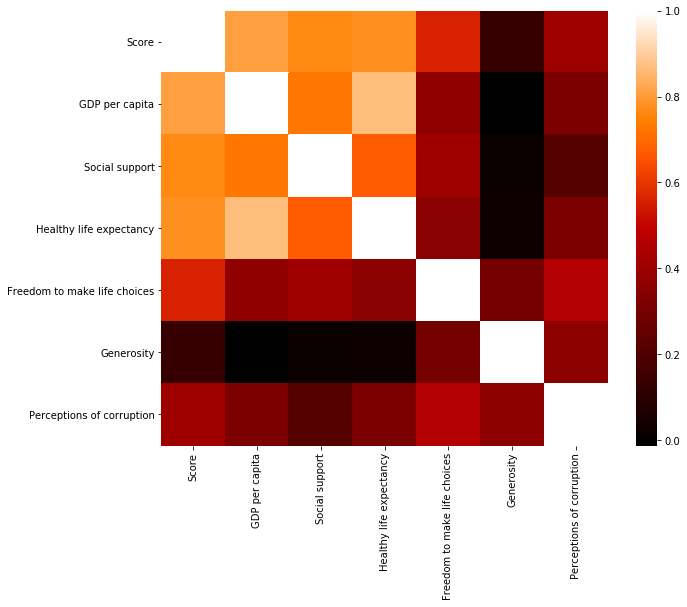

In [3]:
varijable = podaci[podaci.columns]
plt.subplots(figsize=(10,8))
sns.heatmap(varijable.corr(),cmap='gist_heat')

Zaključujemo da je ocjena varijable *Score* jako korelirana s varijablama *GDP per capita*, *Social support* i *Healthy life expectancy*.

<br>

In [4]:
podaci

,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
Country or region,,,,,,,
Finland,7632,1305,1592,874,681,202,393.0
Norway,7594,1456,1582,861,686,286,340.0
Denmark,7555,1351,1590,868,683,284,408.0
Iceland,7495,1343,1644,914,677,353,138.0
Switzerland,7487,1420,1549,927,660,256,357.0
...,...,...,...,...,...,...,...
Yemen,3355,442,1073,343,244,83,64.0
Tanzania,3303,455,991,381,481,270,97.0
South Sudan,3254,337,608,177,112,224,106.0


U promatranoj bazi svi podaci o državama su numerički. Međutim, već iz ovog ispisa vidimo da oni nisu normirani. Zato je potrebno sve podatke dovesti u jednaki raspon (skaliranjem) ili ih normalizirati.

<h4>2.1.1. Normalizacija podataka</h4><a name="normalizacija"></a>

Normalizacijom transformiramo podatke tako da se oni mogu uklopiti u **[normalnu distribuciju](#def2)**. Ona je potpuno određena **[očekivanjem](#def3)** $\mu$ i **[standardnom devijacijom](#def4)** $\sigma$. 

U grafičkom smislu pravac $x = m$, s obzirom na koji je graf funkcije gustoće simetričan, predstavlja pomak od ishodišta dok o $\sigma$ ovisi spljoštenost grafa funkcije.

<h5>Grafički prikaz funkcije gustoće s naglaskom na interval $\mathbf{[0, 1]}$</h5>

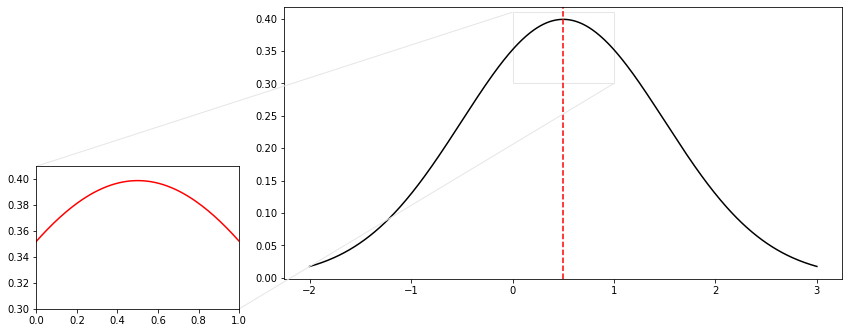

In [5]:
m = 0.5
var = 1
sigma = math.sqrt(var)
x = np.linspace(-2, 3, 500)
y = stats.norm.pdf(x, m, sigma)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x, y, color='black')
plt.axvline(0.5, color='red', linestyle='dashed')

axins = zoomed_inset_axes(ax, 2, loc='lower right', bbox_to_anchor=[50, 10])
axins.plot(x, y, color='red')
x1,x2,y1,y2 = 0, 1, 0.3,.41
axins.set_xlim(x1,x2)
axins.set_ylim(y1,y2)

mark_inset(ax, axins, loc1=2, loc2=4, ec='0.9')
plt.show()

<h5>3D prikaz normalne distribucije na kvadratu $\mathbf{[0, 1]^2}$</h5>

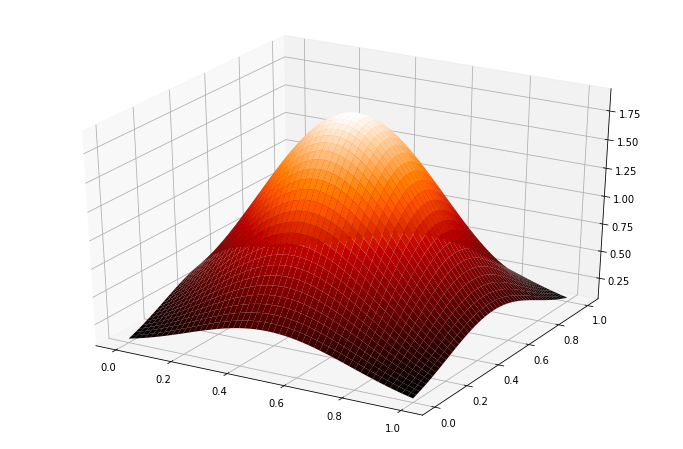

In [6]:
m_x = m_y = 0.5
x = y = np.linspace(0,1,500)

X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

rv = multivariate_normal([m_x, m_y], [[np.var(x), 0], [0, np.var(y)]])

fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos), cmap='gist_heat')

<h5>Normalizacija podataka iz učitane baze na intervalu $\mathbf{[0, 1]}$</h5>

In [7]:
def normaliziraj(podaci):
    return pd.DataFrame(preprocessing.normalize(podaci), index = podaci.index, columns = podaci.columns)

In [8]:
normalizirana_baza = normaliziraj(podaci)

<h5>Provjera normalnosti i intervala</h5>

In [9]:
def test_normalnosti(podaci):
    statistic, pvalue = stats.normaltest(normalizirana_baza)
    for vrijednost in pvalue:
        if round(vrijednost, 2)>0.05:
            return False
    return True

In [10]:
test_normalnosti(normalizirana_baza)

True

In [86]:
def je_li_u_0_1(podaci):
    interval = pd.Interval(left=0, right=1, closed='both')
    if podaci.values.all() not in interval:
        return False          
    return True

In [88]:
je_li_u_0_1(podaci)

True

<h5>Prikaz histograma normaliziranih podataka izabranih stupaca i njihovih Gaussovih krivulja</h5>

In [13]:
def histogram_i_Gaussova_krivulja(ax, baza, stupac, boja):
    ax.set_title(stupac)
    mu, std = norm.fit(baza[stupac])
    ax.hist(baza[stupac], bins=25, density=True,  color=boja)
    x = np.linspace(baza[stupac].min(), baza[stupac].max())
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, color='black')

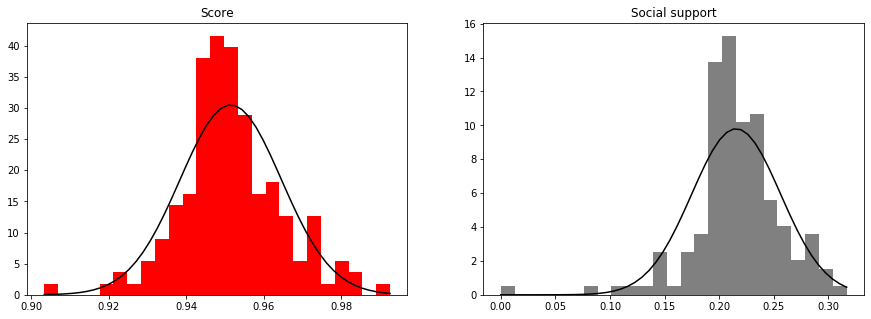

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
histogram_i_Gaussova_krivulja(ax[0], normalizirana_baza, 'Score', 'red')
histogram_i_Gaussova_krivulja(ax[1], normalizirana_baza, 'Social support', 'gray')

<h4>2.1.2. Skaliranje podataka</h4> <a name="skaliranje"></a>

Skaliranjem podacima mijenjamo raspon unutar kojeg se nalaze. Postoji više metoda za skaliranje podataka. Neke od njih su min-max skaliranje, standardizacija, binariziranje podataka, itd.

Detaljnije ćemo promotriti rezultate dobivene min-max skaliranjem. 
Opća formula za min-max skaliranje na interval $[0, 1]$ glasi $$x'= \frac {x-min(x)}{max(x)-min(x)}$$ gdje je $x$ originalna, a $x'$ skalirana vrijednost.  

<h5>Min-max skaliranje podataka iz baze na interval $\mathbf{[0,1]}$</h5>

In [15]:
def skaliraj(podaci):
    return pd.DataFrame(minmax_scale(podaci), index = podaci.index, columns = podaci.columns)

In [143]:
skalirana_baza = skaliraj(podaci)

<h4>2.1.3. Usporedba skaliranih i normaliziranih podataka</h4> <a name="usporedba"></a>

Uvjerimo se prvo da skalirati i normalizirati podatke nije isto.

In [17]:
skalirana_baza['Score'].equals(normalizirana_baza['Score'])

False

Sada ćemo usporediti podatke o varijabli *Score* iz početne baze s podacima u skaliranoj i podacima u normaliziranoj bazi crtanjem histograma.

In [18]:
def histogram(ax, baza, stupac, boja):
    ax.set_title(stupac)
    mu, std = norm.fit(baza[stupac])
    ax.hist(baza[stupac], bins=25, density=True,  color=boja)

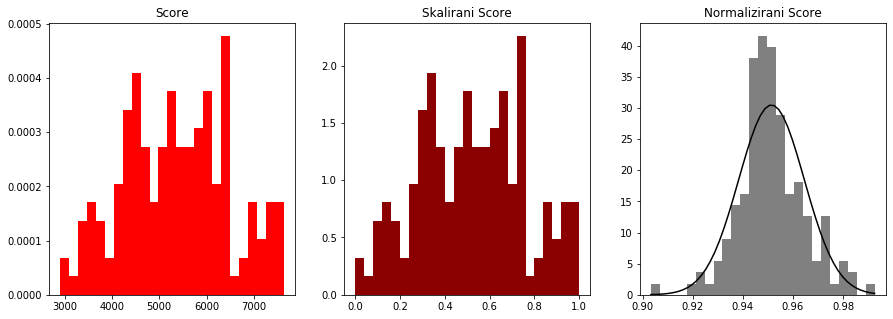

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
histogram(ax[0], podaci, 'Score', 'red')
histogram(ax[1], skalirana_baza, 'Score', 'darkred')
histogram_i_Gaussova_krivulja(ax[2], normalizirana_baza, 'Score', 'gray')
ax[1].set_title('Skalirani Score')
ax[2].set_title('Normalizirani Score')
plt.show()

Usporedbom početnih i skaliranih podataka uočavamo da se skaliranjem promijenio raspon podataka, ali ne i njhov oblik. S normalizacijom to nije slučaj. Funkcija ```normaliziraj``` radikalnije transformira podatke kako bi se mogli uklopiti u normalnu distribuciju. 

U bilježnici ću odsad raditi s normaliziranim podacima.

<h3>2.2. Mjere sličnosti za numeričke varijable</h3><a name="slicnost"></a>

Neka su $x$ i $y$ opisane sa $n$ numeričkih varijabli
$$x = (x_1, x_2, ..., x_n) \\ y = (y_1, y_2, ..., y_n)$$
<br>
Neke od mjera za računanje sličnosti između $x$ i $y$ dane su sljedećim formulama:
* udaljenost Minkowskog
$$ d(x,y) = \left(\sum_{i=1}^{n} \left|x_i-y_i\right|^r\right)^ \frac{1}{r} $$

    * euklidska udaljenost
    $$ d(x,y) = \sqrt {\sum_{i=1}^{n} \left(x_i-y_i\right)^2} $$ 

    * Manhattan udaljenost
    $$ d(x,y) = \sum_{i=1}^{n} \left|x_i-y_i\right| $$ 

    * Čebiševa udaljenost
    $$ d(x,y) = \max_{i=1,...,n} \left|x_i-y_i\right| $$


<h4>Implementacija udaljenosti</h4>

In [138]:
def udaljenost_Minkowskog(niz_1, niz_2, r):
    return distance.minkowski(niz_1, niz_2, r)

In [139]:
def euklidska_udaljenost(niz_1, niz_2):
    return np.linalg.norm(niz_1.values - niz_2.values)

In [140]:
def Manhattan_udaljenost(niz_1, niz_2):
    return distance.cityblock(niz_1, niz_2)

In [115]:
def Čebiševa_udaljenost(niz_1, niz_2):
    return distance.chebyshev(niz_1, niz_2)

<br>

<h3>2.3. Algoritmi klasteriranja</h3><a name="algoritmi"></a>

Općenito, ne postoji objektivno ispravan algoritam klasteriranja. Određni algoritam može dati dobre rezultate na jednom skupu podataka, a loše ili nikakve na drugom, ovisno o dimenziji, strukturi i vrsti podataka.

Neke od karakteristika koje bi trebao imati dobar algoritam klasteriranja su sljedeće:
* sposobnost izvođenja na velikim skupovima podataka
* sposobnost izvođenja na različitim tipovima varijabli
* dobro nošenje s devijacijama
* neovisam o redoslijedu unosa podataka

Osnovna podjela algoritama za grupiranje podataka je na hijerarhijske i nehijerarhijske algoritme. 

<h4>2.3.1. Hijerarhijski algoritmi</h4> <a name="hijerarhijski"></a>

Hijerarhijski algoritmi su bazirani na ideji da su objekti više povezani s objektima koji su im bliži nego s onima koji su im udaljeniji.

Karakteristika takvih algoritama je da u više iteracija formiraju stablo tako da kreću od svih elemenata koje treba grupirati. U sljedećim iteracijama formiraju grupe od više elemenata na temelju njihove međusobne udaljenosti, sve do tražene razine grupiranja. Ovi algoritmi neće proizvesti jedinstvenu podjelu skupa podataka, već hijerarhiju iz koje korisnik još treba odabrati odgovarajuće klastere.

U općenitom slučaju složenost im je $\mathcal{O}(n^{3})$ što ih čini sporima za velike skupove podataka.

Stablo kojim se prikazuje raspored klastera nastalih hijerarhijskim klasteriranjem naziva se **dendrogram**. Sličnost između dva objekta u dendrogramu je reprezentirana visinom najnižeg unutarnjeg čvora kojeg dijele. U koordinatnom sustavu na jednoj koordinatnoj osi vidi se visina na kojoj se pojedini klasteri spajaju, dok su na drugoj osi raspoređeni objekti.

<h5>Primjer dendrograma za promatranu bazu</h5>

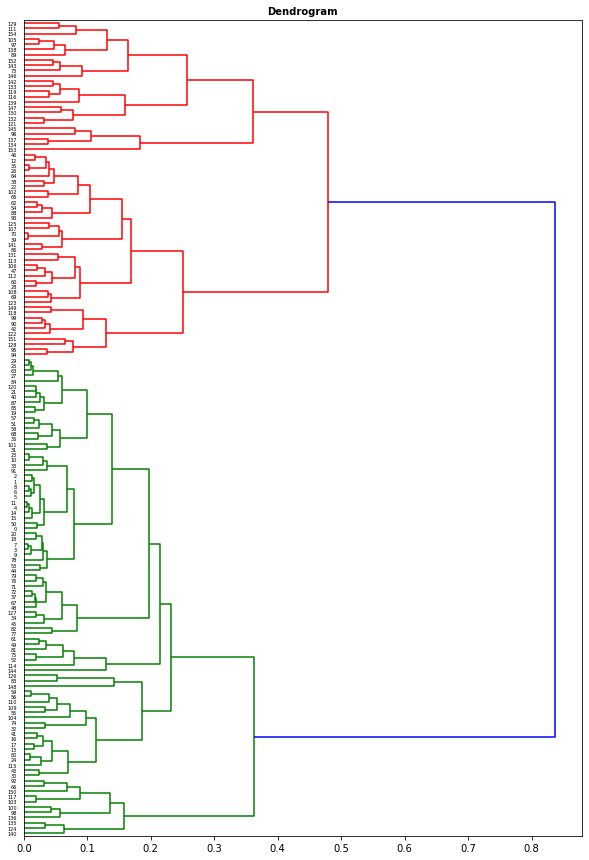

In [20]:
X = normaliziraj(podaci).iloc[:, [0, 1, 2, 3, 4, 5]].values
plt.figure(figsize=(10, 15))

dendrogram = sch.dendrogram( sch.linkage(X, method='ward'), orientation='right' )
plt.title('Dendrogram', fontsize=10, fontweight='bold')
plt.show()

<h4>2.3.1. Nehijerarhijski algoritmi</h4><a name="nehijerarhijski"></a>

Kod nehijararhijskog klasteriranja svaki objekt se smješta u točno jedan od $k$ disjunktnih klastera. Broj klastera mora biti unaprijed određen.

Najpoznatiji nehijerarhijski algoritam je algoritam $k$-srednjih vrijednosti (*k-means*) kojim ćemo se baviti i u ovoj bilježnici.

<h4>Algoritam k-sredina</h4>

Neka je $X=\{x_1, x_2,...,x_n\}$ skup podataka iz d-dimenzionalnog euklidskog prostora $\mathbb{R}^d$. Algoritam patricionira skup $X$ na $k$-klastera. Budući da je ovo nehijerarhijski algoritam, znamo da varijabla $k$ mora biti unaprijed zadana. Algoritam svakom klasteru dodjeljuje predstavnika (centar) na sljedeći način:

$$ c_i=\frac {1}{\left|C_i\right|} \sum_{x \in C_i} x$$ gdje su $C_i \in \{1,2,...,k\}$ klasteri.
<br>
Osnovni algoritam $k$-sredina koristi euklidsku metriku na $\mathbb{R}^d$: $$ F(C) = \sum_{i=1}^{k} \sum_{x \in C_i} \left\|x-c_i\right\|_2^2.$$
Cilj algoritma je pronaći idealnu particiju tako da funkcija cilja ima minimalnu vrijednost. Dakle, tražimo najhomogenije klastere tj. minimiziramo [varijancu](#def4) klastera.

<h5>Primjer algoritma</h5>

Promotrimo prvo _k-means_ algoritam na primjeru dvodimenzionalnog skupa izgeneriranih numeričkih podataka. Broj centara, a time i klastera ograničili smo na tri.

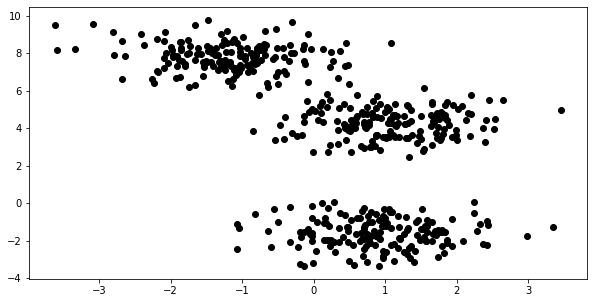

In [21]:
fig = plt.figure(figsize=(10, 5))
X, y = make_blobs(n_samples=500, n_features=3,centers=3, cluster_std=0.8, random_state=0)
ax = plt.scatter(X[:, 0], X[:, 1], color='black')

<h5>2D prikaz rezultata algoritma k-sredina</h5>

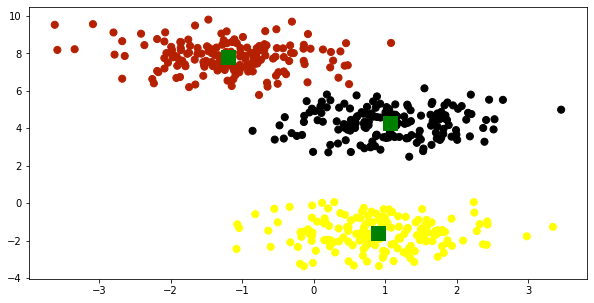

In [128]:
fig = plt.figure(figsize=(10, 5))
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='gnuplot')
centers = kmeans.cluster_centers_
ax = plt.scatter(centers[:, 0], centers[:, 1], c='green', s=200,  marker='s')
plt.show()

<h5>3D prikaz rezultata algoritma k-sredina</h5>

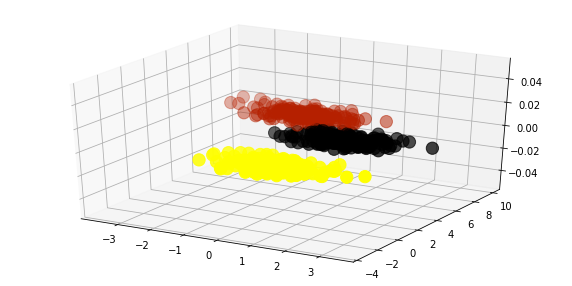

In [23]:
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(projection='3d')

kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=150, cmap='gnuplot')
plt.show()

<h5>Primjena algoritma k-sredina na promatranu bazu</h5>

Prvo ćemo napisati funkciju koja klasterira podatke algoritmom k-sredina. Funkcija vraća niz koji na $k$-tom mjestu sadrži oznaku klastera kojem pripada $k$-ti redak tablice i centar svakog klastera.

In [24]:
def Kmeans_happiness(n_clusters):
    model = KMeans(n_clusters)
    model.fit(normalizirana_baza)
    clusters = model.predict(normalizirana_baza)
    centers = model.cluster_centers_
    return (clusters, centers)

Sada ćemo uz pomoć prethodne funkcije napisat funkciju koja crta raspodjelu podataka u zadani broj klastera. Podaci koji pripadaju istom klasteru biti će jednako obojani. Uz to za svaki klaster računa i crta njegov centar.

In [131]:
def kMeans_happiness_plot(n_clusters, var_1, var_2):
    clusters, centers = Kmeans_happiness(n_clusters)

    plt.scatter(normalizirana_baza[var_1], normalizirana_baza[var_2], c=clusters, s=50, cmap='gnuplot')
    plt.scatter(centers[:,  normalizirana_baza.columns.get_loc(var_1)], 
                centers[:, normalizirana_baza.columns.get_loc(var_2)],
                c='g', s=100, alpha=1, marker='s')
    plt.xlabel(var_1)
    plt.ylabel(var_2)

U nastavku slijede primjeri grafova za zadane varijable koje daje prethodno opisana funkcija.

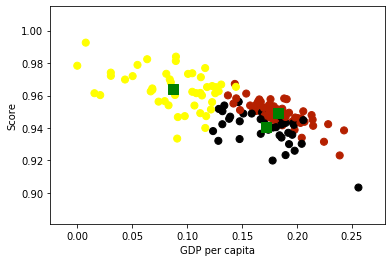

In [132]:
kMeans_happiness_plot(3, 'GDP per capita', 'Score')

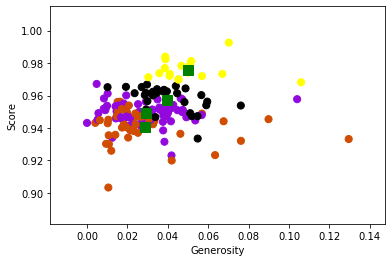

In [133]:
kMeans_happiness_plot(4, 'Generosity', 'Score')

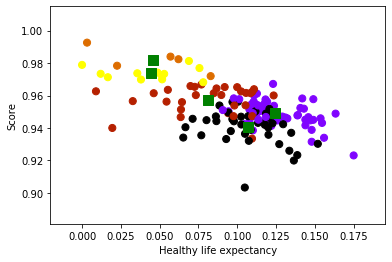

In [134]:
kMeans_happiness_plot(5, 'Healthy life expectancy', 'Score')

<br>

## 2.4. Interpretacija rezultata <a name="rezultat"></a>

Rezultate ćemo interpretirati grafički. Na karti svijeta obojit ćemo države koje se nalaze u bazi prema podatku _Score_ koji nam predstavlja indeks sreće.

<h4>Grafički prikaz početnih normaliziranih podataka</h4>

In [83]:
#Ref: https://plot.ly/python/choropleth-maps/
def nacrtaj_kartu( stupac ):
    baza = dict(type = 'choropleth', locations = normalizirana_baza.index, locationmode = 'country names', 
                z = normalizirana_baza[stupac], text = normalizirana_baza.index, colorbar = {'title':'Score'})
    layout = dict(geo = dict(showframe = False, projection = {'type': 'miller'}), margin={"r":0,"t":0,"l":0,"b":0})
    choromap3 = go.Figure(data = [baza], layout=layout)
    iplot(choromap3)

In [84]:
nacrtaj_kartu('Score')

<h4>Grafički prikaz klasteriranih podataka</h4>

Sada iskoristimo napisanu ```Kmeans_happiness``` funkciju. Kao argument funkciji šaljemo broj dva, a analogno bi mogli provjeriti i za proizvoljan broj klastera.

In [31]:
clusters, centers = Kmeans_happiness(2)
normalizirana_baza.insert(normalizirana_baza.shape[1], 'kmeans', clusters)

Ukoliko je sve dobro napisano karta će biti obojana u dvije boje koje reprezentatiraju dva klastera u koja smo podijelili podatke. Provjerimo.

In [144]:
nacrtaj_kartu('kmeans')

<br>

# 3. Bibliografija <a name="bibliografija"></a>

[1] https://en.wikipedia.org/wiki/Cluster_analysis#Algorithms <br>
[2] https://www.kaggle.com/dhanyajothimani/basic-visualization-and-clustering-in-python/data <br>
[3] https://developers.google.com/machine-learning/clustering <br>
[4] https://repozitorij.pmf.unizg.hr/islandora/object/pmf%3A4641/datastream/PDF/view <br>
[5] https://repozitorij.pmf.unizg.hr/islandora/object/pmf%3A5553/datastream/PDF/view <br>
[6] https://www.mathos.unios.hr/klasteri/Materijali/predavanje1.pdf <br>
[7] https://plotly.com/python/map-configuration/ <br>
[8] http://marjan.fesb.hr/~borka/files/pm-pr7.pdf <br>

<br>

***

<br>